In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import scipy.optimize as sopt
import pydae.ssa as ssa
from pydae.tools import get_i
from pydae.svg_tools import svg
import pydae.plot_tools as pplt
import json
import time
from IPython.core.display import HTML
import sys
from pydae.urisi.utils import report_v
colors = pplt.set_style(plt)

In [3]:
import uac_4b4w2s

In [4]:
model = uac_4b4w2s.model()
model.Dt = 10e-3
model.decimation = 1

In [7]:
model = uac_4b4w2s.model()

p = 30e3
params = {'R_B1_ng':0.0,'X_B1_ng':0.001,'K_p_agc':2,
          'X_B1_s': 0.1,'X_B4_s': 0.1,
          'X_B1_sn':0.1,'X_B4_sn':0.1,
          'K_p_B1': 0.1,'K_p_B4': 0.1,
          'T_p_B1': 0.2,'T_p_B4': 0.2,
          'T_c_B1': 0.2,'T_c_B4': 0.2,
          'T_e_B1': 0.05,'T_e_B4': 0.05,
          'Droop_B1': 0.05,'Droop_B4': 0.05,
          'p_load_B2_a':p,'p_load_B2_b':p,'p_load_B2_c':p,
          'p_load_B3_a':p,'p_load_B3_b':p,'p_load_B3_c':p,
          'phi_n_B1':np.deg2rad(0.0),'v_rn_B1':0.01

        }
model.ini(params,'xy_0.json')
model.ini({'v_rn_B1':0.0,})
##grid.ini({'e_B1_cn':229,'e_B1_cn':232})
#print(grid.get_mvalue(['i_vsc_B1_a_m','i_vsc_B1_b_m','i_vsc_B1_c_m','i_vsc_B1_n_m']))
#print(grid.get_mvalue(['i_vsc_B4_a_m','i_vsc_B4_b_m','i_vsc_B4_c_m','i_vsc_B4_n_m']))
#ssa.A_eval(grid)
#ssa.damp_report(grid)
#bus_results = gt.report_v(grid,'uac_4b4w2s.json',show=False)
#print([bus_results[item]['v_unb']*100 for item in bus_results])
report_v(model,'uac_4b4w2s.json');
#grid.report_u()

V_B1_an:   229.2|   -3.3º V,    V_B1_ag:   229.2|   -3.3º V,    V_1 =   229.2 V, unb = 0.01%
V_B1_bn:   229.2| -123.3º V,    V_B1_bg:   229.2| -123.3º V,    V_2 =     0.0 V
V_B1_cn:   229.2|  116.7º V,    V_B1_cg:   229.2|  116.7º V,    v_0 =     0.0 V
  V_B1_ng:      0.0|     44.2º V
V_B2_an:   223.4|   -3.5º V,    V_B2_ag:   223.5|   -3.5º V,    V_1 =   223.7 V, unb = 0.25%
V_B2_bn:   223.7| -123.5º V,    V_B2_bg:   223.7| -123.5º V,    V_2 =     0.1 V
V_B2_cn:   223.9|  116.6º V,    V_B2_cg:   223.8|  116.5º V,    v_0 =     0.1 V
  V_B2_ng:      0.2|    -26.8º V
V_B3_an:   223.4|   -3.5º V,    V_B3_ag:   223.5|   -3.5º V,    V_1 =   223.7 V, unb = 0.25%
V_B3_bn:   223.7| -123.5º V,    V_B3_bg:   223.7| -123.5º V,    V_2 =     0.1 V
V_B3_cn:   223.9|  116.6º V,    V_B3_cg:   223.8|  116.5º V,    v_0 =     0.1 V
  V_B3_ng:      0.2|    -26.8º V
V_B4_an:   229.2|   -3.3º V,    V_B4_ag:   229.2|   -3.3º V,    V_1 =   229.2 V, unb = 0.01%
V_B4_bn:   229.2| -123.3º V,    V_B4_bg:   229.2|

In [8]:
class opt_class:
    
    def __init__(self,model):
        self.model = model    
        self.x_0 = []      
        self.bounds = []
        self.contraints = False
        self.report = False
        self.obj = ''
        self.cons_var_1 = ''
        self.obj_buses = ['B2','B3']
        self.obj_vscs = ['B1','B4']
        
        self.t = 0.0
        self.obj_evals = 0
        self.compute_jac = False
        self.method = 'SLSQP'
        self.model.I_res_t_max = 720.0
        self.model.I_ind_t_max = 210.0
        self.model.I_com_t_max = 430.0
        
    def set_inputs(self,inputs):

        self.x_0 = [item['ini'] for item in  inputs ]
        self.bounds = [(item['min'],item['max']) for item in  inputs]
        self.inputs_id = [item['id'] for item in inputs]
        
        inputs_run_list = self.model.inputs_run_list
        
        self.idx_u = [inputs_run_list.index(item['id']) for item in inputs]

        params = self.model.params
        
        u = self.x_0
        
        it = 0
        for u_id in self.inputs_id:
            params.update({u_id:u[it]})
            it+=1
            
        self.model.ini(params)
            
        #self.idx_z = grid.outputs_list.index('p_t_AC1_AC2_1')

    def optimize(self):
        
        #res = sopt.minimize(opt.obj_eval, self.x_0, method='SLSQP', bounds=self.bounds, constraints=cons)  #
        #res = sopt.minimize(opt.obj_eval, self.x_0, method='SLSQP', bounds=self.bounds, constraints=cons)  #
        if not self.contraints:
            if self.compute_jac:
                res = sopt.minimize(self.obj_eval, self.x_0, method=self.method, bounds=self.bounds, jac=self.jac_eval)  #
            else:
                res = sopt.minimize(self.obj_eval, self.x_0, method=self.method, bounds=self.bounds) 
                
        if self.contraints:
            #res = sopt.minimize(opt.obj_eval, x0, method='trust-constr', bounds=bounds)  # SLSQP, Powell, COBYLA,trust-constr
            #cons_1 = {'type':'ineq','fun':self.cons_res}
            #cons_2 = {'type':'ineq','fun':self.cons_ind}
            #cons_3 = {'type':'ineq','fun':self.cons_com}

            #nlc = NonlinearConstraint(self.cons_1, -30, 30)
            #cons = [cons_1,cons_2,cons_3]
            
            cons = NonlinearConstraint(self.cons_1, -30, 30)

            if self.compute_jac:
                res = sopt.minimize(self.obj_eval, self.x_0, method=self.method, bounds=self.bounds, jac=self.jac_eval, constraints=cons)  #
            else:
                res = sopt.minimize(self.obj_eval, self.x_0, method=self.method, bounds=self.bounds, constraints=cons)  #
        #SLSQP, Powell,trust-constr
        
        self.res = res
        self.x_0 = res.x 
        return res.x
    
    def jac_eval(self,u):
        self.model.eval_jac_u2z()
        self.idx_z = self.model.outputs_list.index(self.obj)
               
        return self.model.jac_u2z[self.idx_z,self.idx_u].toarray()
        
 
    def obj_eval(self,u):
        
        self.obj_evals +=1
        
        params = self.model.params
        
        it = 0
        for u_id in self.inputs_id:
            params.update({u_id:u[it]})
            it+=1
        
        self.model.ini(params)
        v_abc_m = []
        obj_value = 0.0
        V_nom = 400.0/np.sqrt(3)
        for bus in self.obj_buses:
            V_an,V_bn,V_cn = self.model.get_mvalue([f"V_{bus}_an",f"V_{bus}_bn",f"V_{bus}_cn"])
            obj_value += (V_an-V_nom)**2 + (V_bn-V_nom)**2 + (V_cn-V_nom)**2
        for vsc in self.obj_vscs:
            for ph in ['a','b','c','n']:
                i_m = self.model.get_value(f"i_vsc_{vsc}_{ph}_m")  
                obj_value += 0.1*i_m

                #bus_results = gt.report_v(grid,'uac_4b4w2s.json',show=False)
        str_out = ''
        if self.report:
            str_out+= f"t: {time.strftime('%H:%M:%S', time.gmtime(self.t))}, "
            str_out+= f"V_a_m: {V_an:4.0f} V, "
            str_out+= f"V_b_m: {V_bn:4.0f} V, "
            str_out+= f"V_c_m: {V_cn:4.0f} V, "
            str_out+= f" Obj evals = {self.obj_evals} "
            sys.stdout.write("\r" + str_out  )
            sys.stdout.flush()
        
        self.u = u
        return obj_value
    
    def cons_res(self,u):
 
        it = 0
        for u_id in self.inputs_id:
            params.update({u_id:u[it]})
            it+=1
        
        self.model.ini(self.model.params)
        
        return self.model.I_res_t_max - self.model.get_value('i_res') 

    def cons_ind(self,u):
 
        it = 0
        for u_id in self.inputs_id:
            params.update({u_id:u[it]})
            it+=1
        
        self.model.ini(self.model.params)
        
        return self.grid.I_ind_t_max - self.model.get_value('i_ind') 
    
    def cons_i_vsc_B1_a_m(self,u):

        it = 0
        for u_id in self.inputs_id:
            self.model.params.update({u_id:u[it]})
            it+=1
        self.model.ini(self.model.params)

        return self.model.get_value('i_vsc_B1_a_m') 

 

    def cons_com(self,u):

        it = 0
        for u_id in self.inputs_id:
            params.update({u_id:u[it]})
            it+=1
        
        self.model.ini(self.model.params)
        
        return self.model.I_com_t_max - self.model.get_value('i_com') 

In [9]:
p = 30e3
params = {'R_B1_ng':0.0,'X_B1_ng':0.001,'K_p_agc':0.001,'K_i_agc':0.001,
          'X_B1_s': 0.1,'X_B4_s': 0.1,
          'X_B1_sn':0.1,'X_B4_sn':0.1,
          'K_p_B1': 0.2,'K_p_B4': 0.2,
          'T_p_B1': 0.1,'T_p_B4': 0.1,
          'Droop_B1': 0.05,'Droop_B4': 0.05,
          'p_load_B2_a':50e3,'p_load_B2_b':0,'p_load_B2_c':0,
          'p_load_B3_a':p,'p_load_B3_b':p,'p_load_B3_c':p,
        }
     
model.ini(params,'xy_0.json')


V_nom = 400/np.sqrt(3) 
V_min = 400/np.sqrt(3)*0.8
V_max = 400/np.sqrt(3)*1.2

 
inputs_e = [{'id':'e_ao_m_B1','min':V_min,'max':V_max,'ini':V_nom},
            {'id':'e_bo_m_B1','min':V_min,'max':V_max,'ini':V_nom},
            {'id':'e_co_m_B1','min':V_min,'max':V_max,'ini':V_nom},
            {'id':'e_ao_m_B4','min':V_min,'max':V_max,'ini':V_nom},
            {'id':'e_bo_m_B4','min':V_min,'max':V_max,'ini':V_nom},
            {'id':'e_co_m_B4','min':V_min,'max':V_max,'ini':V_nom},]

phi_min = np.deg2rad(-0.1)
phi_max = np.deg2rad( 0.1)

inputs_a = [{'id':'phi_a_B1','min':phi_min,'max':phi_max,'ini':0.0},
            {'id':'phi_b_B1','min':phi_min,'max':phi_max,'ini':0.0},
            {'id':'phi_c_B1','min':phi_min,'max':phi_max,'ini':0.0},
            {'id':'phi_a_B4','min':phi_min,'max':phi_max,'ini':0.0},
            {'id':'phi_b_B4','min':phi_min,'max':phi_max,'ini':0.0},
            {'id':'phi_c_B4','min':phi_min,'max':phi_max,'ini':0.0},]

inputs = inputs_e #+ inputs_a

opt = opt_class(model)
opt.obj_buses = ['B2']
opt.report = True
opt.model.params = params
opt.set_inputs(inputs)
opt.model.ini({},'xy_0.json')
opt.contraints = True
opt.method = 'SLSQP'
opt.optimize()
opt.res

print('\n\n')
report_v(model,'uac_4b4w2s.json');

NameError: name 'NonlinearConstraint' is not defined

In [10]:
model = uac_4b4w2s.model()
model.Dt = 10e-3
model.decimation = 1

p = 30e3
params = {'R_B1_ng':0.0,'X_B1_ng':0.001,'K_p_agc':0.01,'K_i_agc':0.01,
          'X_B1_s': 0.05,'X_B4_s': 0.05,
          'X_B1_sn':0.1,'X_B4_sn':0.1,
          'K_p_B1': 0.1,'K_p_B4': 0.1,
          'T_p_B1': 0.2,'T_p_B4': 0.2,
          'T_c_B1': 0.2,'T_c_B4': 0.2,
          'T_e_B1': 0.1,'T_e_B4': 0.1,
          'Droop_B1': 0.05,'Droop_B4': 0.05,
          'p_load_B2_a':p,'p_load_B2_b':0,'p_load_B2_c':0,
          'p_load_B3_a':p,'p_load_B3_b':p,'p_load_B3_c':p,
        }

Δt_small = 0.1
times = np.arange(0,10,Δt_small) # seconds

model.ini(params,'xy_0.json')
p_B2 = p
p_B3 = p
#it = 0
for it,t in enumerate(times):
            
    p_B2 = 0
    if t>1.0:
        p_B2 = 40e3

    model.run(t,{'p_load_B2_a':p_B2,'p_load_B2_b':  0,'p_load_B2_c':  0,
                'p_load_B3_a':p_B3,'p_load_B3_b':  p_B3,'p_load_B3_c':  p_B3,})
    
model.post();

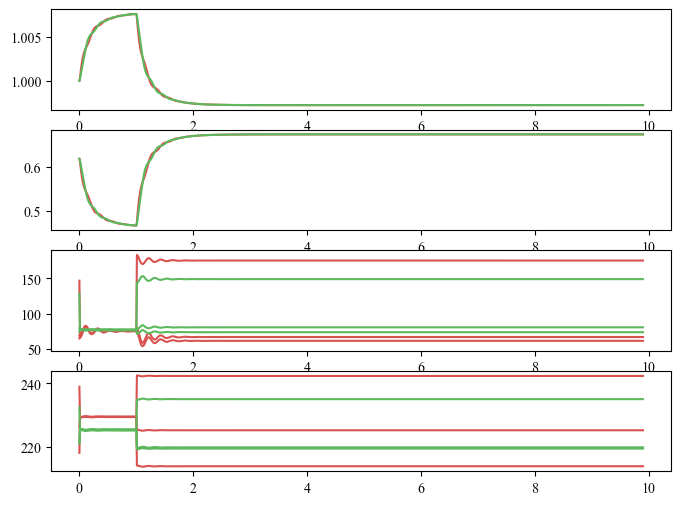

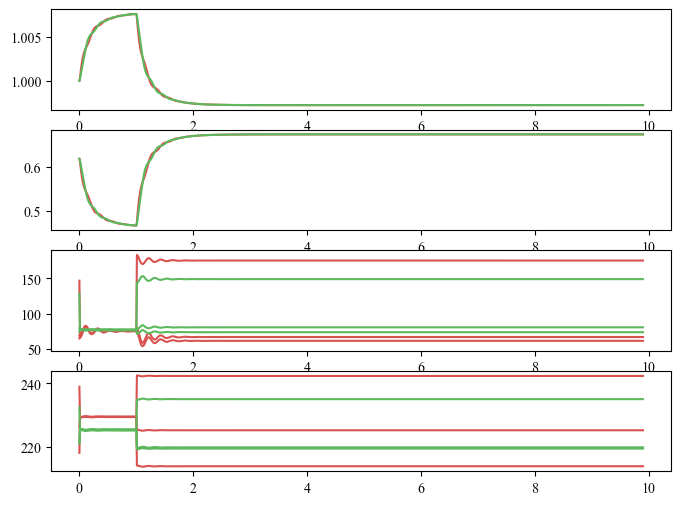

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 6))

for vsg in ['B1','B4']:
    axes[0].plot(model.Time, model.get_values(f'omega_{vsg}'), label='$\omega_{vsg}$')

for vsg in ['B1','B4']:
    axes[1].plot(model.Time, model.get_values(f'p_m_{vsg}'), label='$\omega_{vsg}$')

for iv,vsg in enumerate(['B1','B4']):
    axes[2].plot(model.Time, model.get_values(f'i_vsc_{vsg}_a_m'), label='i_vsc_{vsg}_a_m', color=colors[iv])
    axes[2].plot(model.Time, model.get_values(f'i_vsc_{vsg}_b_m'), label='i_vsc_{vsg}_b_m', color=colors[iv])
    axes[2].plot(model.Time, model.get_values(f'i_vsc_{vsg}_c_m'), label='i_vsc_{vsg}_c_m', color=colors[iv])
    
for iv,bus in enumerate(['B2','B3']):
    axes[3].plot(model.Time, model.get_values(f'V_{bus}_an'), label='i_vsc_{vsg}_a_m', color=colors[iv])
    axes[3].plot(model.Time, model.get_values(f'V_{bus}_bn'), label='i_vsc_{vsg}_b_m', color=colors[iv])
    axes[3].plot(model.Time, model.get_values(f'V_{bus}_cn'), label='i_vsc_{vsg}_c_m', color=colors[iv])
    
fig

## Loads definition

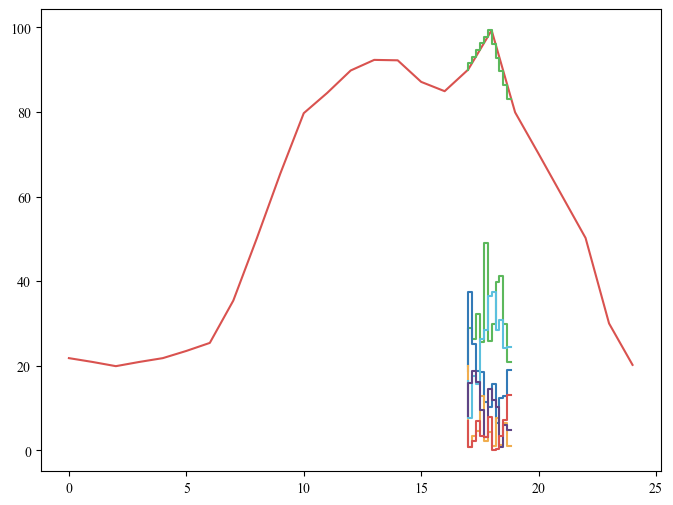

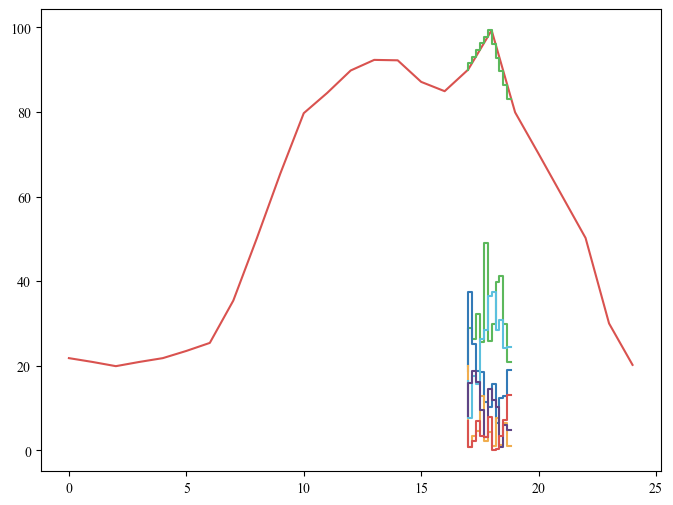

In [12]:
shapes = gt.read_shapes('uac_4b4w2s.json')  # shapes time in hours
times = np.arange(17*60,19*60,10)*60 # seconds
values = np.interp(times,shapes['com']['t']*3600,shapes['com']['val'])

N_l = 6
N_t = len(times)
values_arr = np.zeros((N_t,N_l))
cum_randoms = np.zeros(N_l)
for it in range(N_t):
    cum_randoms += (np.random.rand(N_l)-0.5)
    total = np.sum(np.abs(cum_randoms))
    factors = np.abs(cum_randoms/total)
    
    for il in range(N_l):
        values_arr[it,:] = factors*values[it]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(shapes['com']['t'],shapes['com']['val'], label='$\omega_{coi}$')

for il in range(N_l):
    axes.step(times/3600,values_arr[:,il], label='$\omega_{coi}$')
axes.step(times/3600,np.sum(values_arr,axis=1), label='$\omega_{coi}$')

fig

## Time domain using digital twin

In [13]:
Δt_small = 0.1
Δt_mid = 1.0
Δt_large = times[1]-times[0]
loads = values_arr*1000

it = 0
# simulate one large step

params = {'R_B1_ng':0.0,'X_B1_ng':0.001,'K_p_agc':0.01,'K_i_agc':1000,
        #  'K_f_B1':0.05,'K_f_B4':0.05,
        #  'T_f_B1':0.1,'T_f_B4':0.1,
          'X_B1_s': 0.1,'X_B4_s': 0.1,
          'X_B1_sn':0.1,'X_B4_sn':0.1
        }

params_loads = {
'p_load_B2_a': loads[it,0],'p_load_B2_b':loads[it,1],'p_load_B2_c':loads[it,2],
'p_load_B3_a': loads[it,3],'p_load_B3_b':loads[it,4],'p_load_B3_c':loads[it,5]}

params.update(params_loads)

model_noopt = uac_4b4w2s.model()
model = uac_4b4w2s.model()
model_dtwin = uac_4b4w2s.model()

model_noopt.ini(params,'xy_0.json')
model.ini(params,'xy_0.json')
model_dtwin.ini(params,'xy_0.json')

opt = opt_class(model_dtwin)
opt.obj_buses = ['B2','B3']
opt.report = True
opt.contraints = True
opt.model.params = params
opt.set_inputs(inputs)
opt.model.ini({},'xy_0.json')

opt.method = 'Powell'
opt.optimize()

times_mid = np.arange(0.0,Δt_large,20) # seconds

#it = 0
for it,t in enumerate(times-times[0]):  # 10 minutes iteration (for load changes)
            
    # simulate one large step
    params_loads = {
    'p_load_B2_a': loads[it,0],'p_load_B2_b':loads[it,1],'p_load_B2_c':loads[it,2],
    'p_load_B3_a': loads[it,3],'p_load_B3_b':loads[it,4],'p_load_B3_c':loads[it,5]}

    # digital twin
    opt.model.params.update(params_loads)
    opt.t = t
    opt.optimize()

    u = opt.res.x
    params_u = {'e_ao_m_B1':u[0],'e_bo_m_B1':u[1],'e_co_m_B1':u[2],
                'e_ao_m_B4':u[3],'e_bo_m_B4':u[4],'e_co_m_B4':u[5]}          

    params_u.update(params_loads)

    model.Dt = Δt_small
    model_noopt.Dt = Δt_small

    for it_mid,t_mid in enumerate(times_mid):

        # model following digital twin parameters
        
        model.run(t+t_mid,params_u)

        # model with fix voltages
        
        model_noopt.run(t+t_mid,params_loads)

        # model_dtwin.Dt = Δt_small
        # model_dtwin.run(t-Δt_large+1,params_loads) 


    model.Dt = Δt_mid
    model.run(t+t_mid+Δt_large,{})
          
    model_noopt.Dt = Δt_mid
    model_noopt.run(t+t_mid+Δt_large,{})
    
        # # grid_noopt.Dt = Δt_mid
        # # grid_noopt.run(t,params_loads)
    
model.post();
model_noopt.post();

NameError: name 'NonlinearConstraint' is not defined

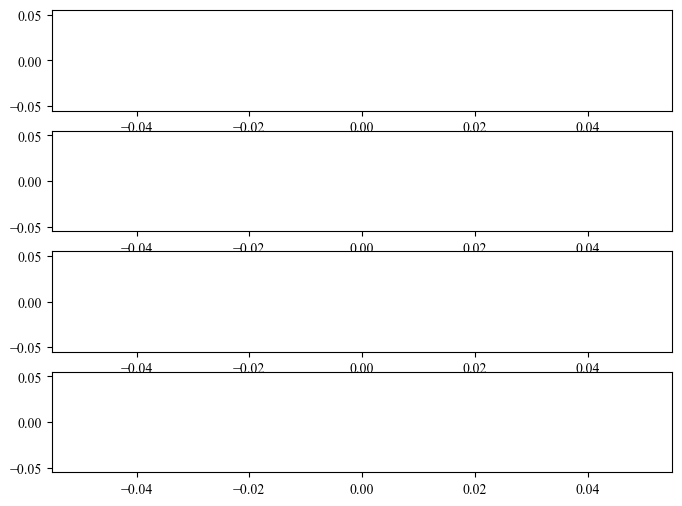

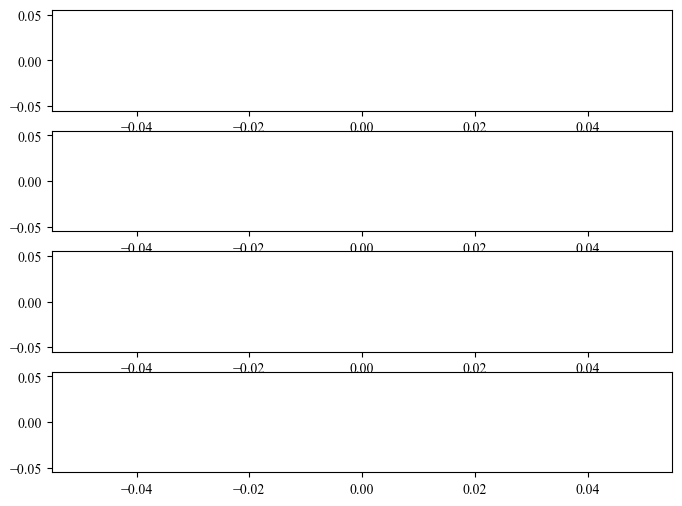

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 6))

for vsg in ['B1','B4']:
    axes[0].plot(model.Time/3600, model.get_values(f'omega_{vsg}'), label='$\omega_{vsg}$')

for vsg in ['B1','B4']:
    axes[1].plot(model.Time/3600, model.get_values(f'p_m_{vsg}'), label='$\omega_{vsg}$')

for iv,vsg in enumerate(['B1','B4']):
    axes[2].plot(model.Time/3600, model.get_values(f'i_vsc_{vsg}_a_m'), label='i_vsc_{vsg}_a_m', color=colors[iv])
    axes[2].plot(model.Time/3600, model.get_values(f'i_vsc_{vsg}_b_m'), label='i_vsc_{vsg}_b_m', color=colors[iv])
    axes[2].plot(model.Time/3600, model.get_values(f'i_vsc_{vsg}_c_m'), label='i_vsc_{vsg}_c_m', color=colors[iv])


for iv,vsg in enumerate(['B1','B4']):
    axes[2].plot(model_noopt.Time/3600, model_noopt.get_values(f'i_vsc_{vsg}_a_m'), label='i_vsc_{vsg}_a_m', color=colors[iv], alpha=0.1)
    axes[2].plot(model_noopt.Time/3600, model_noopt.get_values(f'i_vsc_{vsg}_b_m'), label='i_vsc_{vsg}_b_m', color=colors[iv], alpha=0.1)
    axes[2].plot(model_noopt.Time/3600, model_noopt.get_values(f'i_vsc_{vsg}_c_m'), label='i_vsc_{vsg}_c_m', color=colors[iv], alpha=0.1)


for iv,bus in enumerate(['B2','B3']):
    axes[3].plot(model.Time/3600, model.get_values(f'V_{bus}_an'), label='i_vsc_{vsg}_a_m', color=colors[iv])
    axes[3].plot(model.Time/3600, model.get_values(f'V_{bus}_bn'), label='i_vsc_{vsg}_b_m', color=colors[iv])
    axes[3].plot(model.Time/3600, model.get_values(f'V_{bus}_cn'), label='i_vsc_{vsg}_c_m', color=colors[iv])

for iv,bus in enumerate(['B2','B3']):
    axes[3].plot(model_noopt.Time/3600, model_noopt.get_values(f'V_{bus}_an'), label='i_vsc_{vsg}_a_m', color=colors[iv], alpha=0.2)
    axes[3].plot(model_noopt.Time/3600, model_noopt.get_values(f'V_{bus}_bn'), label='i_vsc_{vsg}_b_m', color=colors[iv], alpha=0.2)
    axes[3].plot(model_noopt.Time/3600, model_noopt.get_values(f'V_{bus}_cn'), label='i_vsc_{vsg}_c_m', color=colors[iv], alpha=0.2)


fig

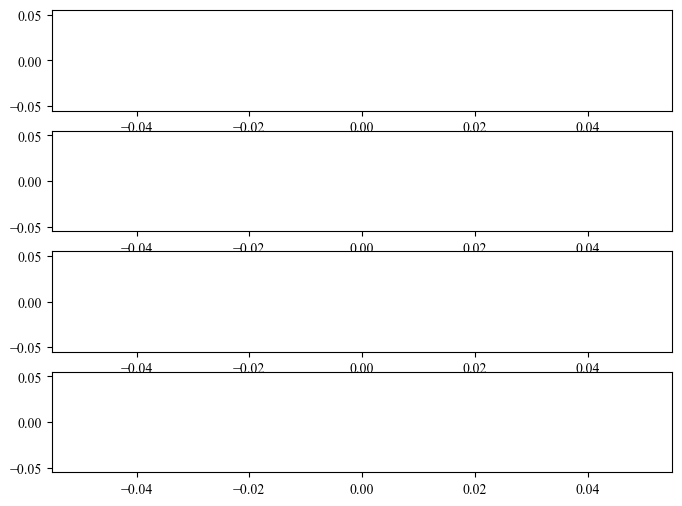

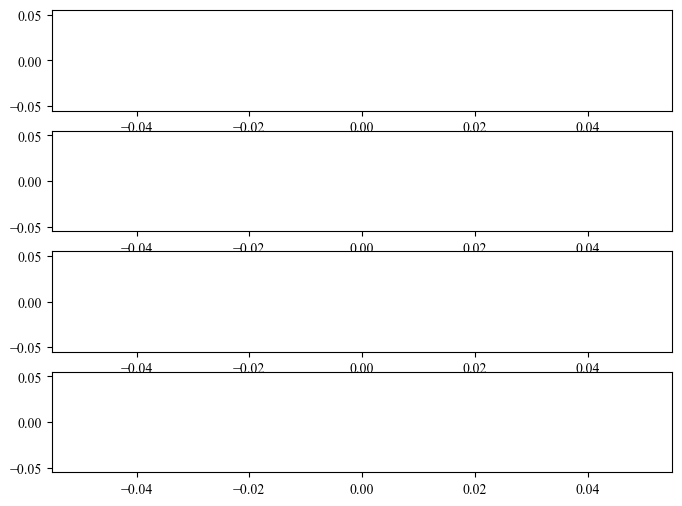

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 6))

for vsg in ['B1','B4']:
    axes[0].plot(model_noopt.Time, model_noopt.get_values(f'omega_{vsg}'), label='$\omega_{vsg}$')

for vsg in ['B1','B4']:
    axes[1].plot(model.Time, model_noopt.get_values(f'p_m_{vsg}'), label='$\omega_{vsg}$')

for iv,vsg in enumerate(['B1','B4']):
    axes[2].plot(model_noopt.Time, model_noopt.get_values(f'i_vsc_{vsg}_a_m'), label='i_vsc_{vsg}_a_m', color=colors[iv])
    axes[2].plot(model_noopt.Time, model_noopt.get_values(f'i_vsc_{vsg}_b_m'), label='i_vsc_{vsg}_b_m', color=colors[iv])
    axes[2].plot(model_noopt.Time, model_noopt.get_values(f'i_vsc_{vsg}_c_m'), label='i_vsc_{vsg}_c_m', color=colors[iv])
    
for iv,bus in enumerate(['B2','B3']):
    axes[3].plot(model_noopt.Time/3600, model_noopt.get_values(f'V_{bus}_an'), label='i_vsc_{vsg}_a_m', color=colors[iv])
    axes[3].plot(model_noopt.Time/3600, model_noopt.get_values(f'V_{bus}_bn'), label='i_vsc_{vsg}_b_m', color=colors[iv])
    axes[3].plot(model_noopt.Time/3600, model_noopt.get_values(f'V_{bus}_cn'), label='i_vsc_{vsg}_c_m', color=colors[iv])

for iv,bus in enumerate(['B2','B3']):
    axes[3].plot(model.Time/3600, model.get_values(f'V_{bus}_an'), label='i_vsc_{vsg}_a_m', color=colors[iv], alpha=0.1)
    axes[3].plot(model.Time/3600, model.get_values(f'V_{bus}_bn'), label='i_vsc_{vsg}_b_m', color=colors[iv], alpha=0.1)
    axes[3].plot(model.Time/3600, model.get_values(f'V_{bus}_cn'), label='i_vsc_{vsg}_c_m', color=colors[iv], alpha=0.1)


fig

In [85]:
model.report_z()

i_l_B1_0_B2_0_r = 199.46
i_l_B1_0_B2_0_i = -33.61
i_l_B1_1_B2_1_r = -17.01
i_l_B1_1_B2_1_i = -56.70
i_l_B1_2_B2_2_r = -45.52
i_l_B1_2_B2_2_i = 45.65
i_l_B1_3_B2_3_r = -136.93
i_l_B1_3_B2_3_i = 44.76
i_l_B2_0_B3_0_r = -38.46
i_l_B2_0_B3_0_i =  2.25
i_l_B2_1_B3_1_r = -17.01
i_l_B2_1_B3_1_i = -56.70
i_l_B2_2_B3_2_r = -45.52
i_l_B2_2_B3_2_i = 45.65
i_l_B2_3_B3_3_r = 101.00
i_l_B2_3_B3_3_i =  8.90
i_l_B3_0_B4_0_r = -175.73
i_l_B3_0_B4_0_i = 21.27
i_l_B3_1_B4_1_r = 49.39
i_l_B3_1_B4_1_i = 50.64
i_l_B3_2_B4_2_r = 23.50
i_l_B3_2_B4_2_i = -72.69
i_l_B3_3_B4_3_r = 102.85
i_l_B3_3_B4_3_i =  0.87
V_B1_an = 222.17
V_B1_bn = 246.16
V_B1_cn = 223.50
V_B1_ng = 14.48
V_B1_ab = 389.65
V_B1_bc = 401.96
V_B1_ca = 403.69
V_B2_an = 207.80
V_B2_bn = 245.98
V_B2_cn = 225.36
V_B2_ng = 16.72
V_B2_ab = 381.05
V_B2_bc = 398.29
V_B2_ca = 393.87
V_B3_an = 216.48
V_B3_bn = 237.68
V_B3_cn = 218.98
V_B3_ng = 11.89
V_B3_ab = 380.74
V_B3_bc = 391.58
V_B3_ca = 391.63
V_B4_an = 228.01
V_B4_bn = 237.93
V_B4_cn = 220.17
V_B

NameError: name 'gt' is not defined

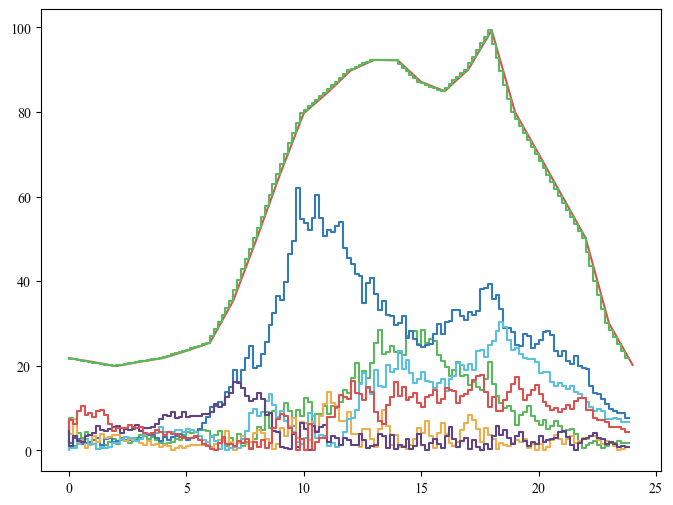

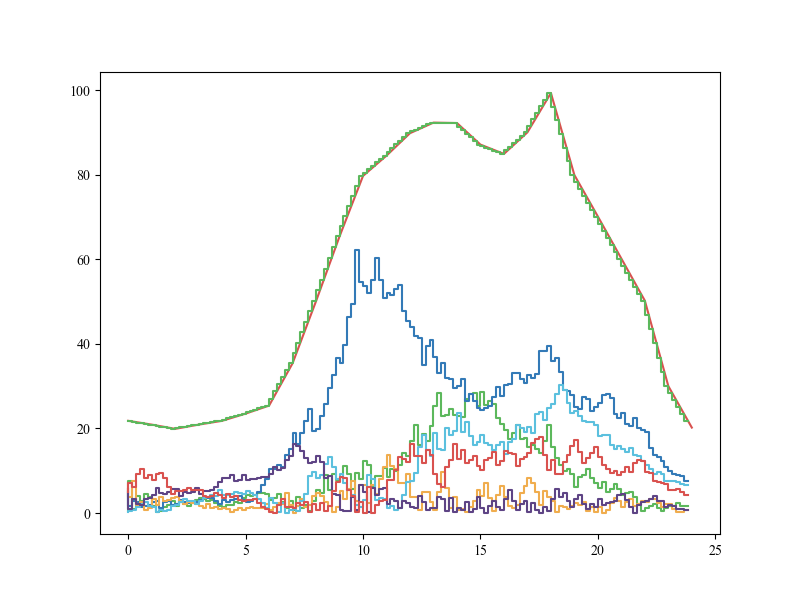

In [ ]:
N_l = 6
N_t = len(times)
values_arr = np.zeros((N_t,N_l))

for it in range(N_t):
    randoms = np.random.normal(loc=1,scale=0.05,size=N_l)
    total = np.sum(randoms)
    factors = randoms/total
    
    for il in range(N_l):
        values_arr[it,:] = factors*values[it]

NameError: name 'values' is not defined

In [ ]:
Δt_small = 0.1
Δt_mid = 1.0
Δt_large = times[1]-times[0]
loads = values_arr*1000

it = 0
# simulate one large step

params = {'R_B1_ng':0.0,'X_B1_ng':0.001,'K_agc':5e6,
          'K_f_B1':0.05,'K_f_B4':0.05,
          'T_f_B1':0.1,'T_f_B4':0.1,
          'X_B1_s': 0.1,'X_B4_s': 0.1,
          'X_B1_sn':0.1,'X_B4_sn':0.1
        }

params_loads = {
'p_load_B2_a': loads[it,0],'p_load_B2_b':loads[it,1],'p_load_B2_c':loads[it,2],
'p_load_B3_a': loads[it,3],'p_load_B3_b':loads[it,4],'p_load_B3_c':loads[it,5]}

params.update(params_loads)

grid     = uac_4b4w2s.uac_4b4w2s_class()
grid_noopt = uac_4b4w2s.uac_4b4w2s_class()
grid_opt = uac_4b4w2s.uac_4b4w2s_class()

grid.ini(params,'xy_2_dict.json')
grid.save_xy_0('xy0_dict.json')

grid.ini(params,'xy0_dict.json')
grid_noopt.ini(params,'xy0_dict.json')
grid_opt.ini(params,'xy0_dict.json')

opt = opt_class(grid_opt)
opt.obj_buses = ['B2','B3']
opt.report = True
opt.grid.params = params
opt.set_inputs(inputs)
opt.grid.ini({})
opt.grid.eval_preconditioner_ini()

opt.method = 'Powell'
opt.optimize()

#it = 0
for it,t in enumerate(times):
            
    # simulate one large step
    params_loads = {
    'p_load_B2_a': loads[it,0],'p_load_B2_b':loads[it,1],'p_load_B2_c':loads[it,2],
    'p_load_B3_a': loads[it,3],'p_load_B3_b':loads[it,4],'p_load_B3_c':loads[it,5]}
    
    grid.Dt = Δt_small
    grid.run(t-Δt_large+1,params_loads)
    
    grid_noopt.Dt = Δt_small
    grid_noopt.run(t-Δt_large+1,params_loads) 
    
    opt.grid.params.update(params_loads)
    opt.t = t
    opt.optimize()
    
    u = opt.res.x
    params_u = {'e_B1_am_m':u[0],'e_B1_bm_m':u[1],'e_B1_cm_m':u[2],
                'e_B4_am_m':u[3],'e_B4_bm_m':u[4],'e_B4_cm_m':u[5]}          

    params_u.update(params_loads)
    grid.run(t-Δt_large+2,params_u)

    grid.Dt = Δt_mid
    grid.run(t,params_u)
    grid_noopt.Dt = Δt_mid
    grid_noopt.run(t,params_loads)
    
grid.post();
grid_noopt.post();

AttributeError: module 'uac_4b4w2s' has no attribute 'uac_4b4w2s_class'

UnboundLocalError: local variable 'values' referenced before assignment

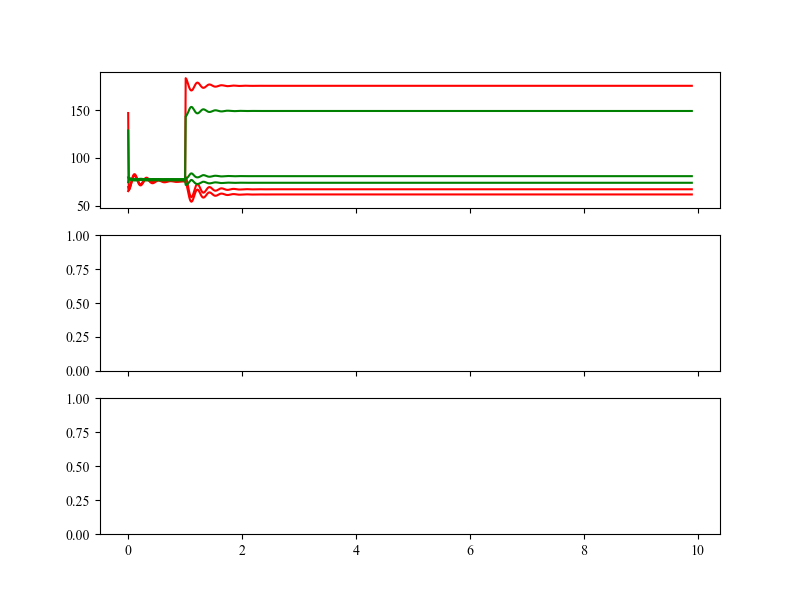

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), sharex=True)

# VSCs currents
vsc = 'B1' 
for ph in ['a','b','c']:
    axes[0].plot(grid.Time,grid.get_values(f"i_vsc_{vsc}_{ph}_m"), 'r',label='$\omega_{coi}$')
vsc = 'B4'
for ph in ['a','b','c']:
    axes[0].plot(grid.Time,grid.get_values(f"i_vsc_{vsc}_{ph}_m"), 'g',label='$\omega_{coi}$')

# VSCs internal voltages
bus = 'B1' # e_B1_am_m
for ph in ['a','b','c']: 
    axes[1].plot(grid.Time,grid.get_values(f"e_{bus}_{ph}m_m"), 'r',label='$\omega_{coi}$')
bus = 'B4'
for ph in ['a','b','c']:
    axes[1].plot(grid.Time,grid.get_values(f"e_{bus}_{ph}m_m"), 'g',label='$\omega_{coi}$')
    
V_n = 400/np.sqrt(3)
# Loads voltages    

axes[2].plot([0,grid_noopt.Time[-1]],[0.95*V_n]*2, 'r')
axes[2].plot([0,grid_noopt.Time[-1]],[1.05*V_n]*2, 'r')

    
bus = 'B2'
for ph in ['a','b','c']: 
    axes[2].plot(grid_noopt.Time,grid_noopt.get_values(f"v_{bus}_{ph}_m"), 'r',alpha=0.4,label='$\omega_{coi}$')
bus = 'B3'
for ph in ['a','b','c']:
    axes[2].plot(grid_noopt.Time,grid_noopt.get_values(f"v_{bus}_{ph}_m"), 'r',alpha=0.4,label='$\omega_{coi}$')

bus = 'B2'
for ph in ['a','b','c']: 
    axes[2].plot(grid.Time,grid.get_values(f"v_{bus}_{ph}_m"), 'b',label='$\omega_{coi}$')
bus = 'B3'
for ph in ['a','b','c']:
    axes[2].plot(grid.Time,grid.get_values(f"v_{bus}_{ph}_m"), 'b',label='$\omega_{coi}$')

axes[2].plot([0,grid_noopt.Time[-1]],[V_n]*2, 'g', lw=2)
    
#axes.plot(times,loads, label='$\omega_{coi}$')


In [ ]:
N=2.0
np.linalg.norm(np.array([2,4]),np.inf)

In [ ]:
np.linalg.norm?

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), sharex=True)



In [ ]:
def get_i_l(grid,bus_j,bus_k,phase):
    i_l_r,i_l_i = grid.get_mvalue([f'i_l_{bus_j}_{bus_k}_{phase}_r',f'i_l_{bus_j}_{bus_k}_{phase}_i'])
    return i_l_r + 1j*i_l_i

def get_il(grid,bus_j,bus_k,phase):
    i_l_r = grid.get_values(f'i_l_{bus_j}_{bus_k}_{phase}_r')
    i_l_i = grid.get_values(f'i_l_{bus_j}_{bus_k}_{phase}_i')
    return i_l_r + 1j*i_l_i

def get_v(grid,bus,phase):
    v_r,v_i = grid.get_mvalue([f'v_{bus}_{phase}_r',f'v_{bus}_{phase}_i'])
    return v_r + 1j*v_i

def get_vs(grid,bus,phase):
    v_r = grid.get_values(f'v_{bus}_{phase}_r')
    v_i = grid.get_values(f'v_{bus}_{phase}_i')
    return v_r + 1j*v_i

def get_vns(grid,bus,phase):
    v_r = grid.get_values(f'v_{bus}_{phase}_r')
    v_i = grid.get_values(f'v_{bus}_{phase}_i')
    v_nr = grid.get_values(f'v_{bus}_n_r')
    v_ni = grid.get_values(f'v_{bus}_n_i')
    v_ph = v_r + 1j*v_i
    v_n  = v_nr + 1j*v_ni 
    return v_ph - v_n 

np.abs(get_vns(grid,'B4','a'))

In [ ]:
grid.report_z()

In [ ]:
grid = uac_4b4w2s.uac_4b4w2s_class()


xy_0_dict = {}
for bus in ['B1','B2','B3','B4']:
    for ph in ['a','b','c']:
        pass
        #xy_0_dict.update({f'v_{bus}_{ph}_r':grid.get_value(f'e_B1_{ph}n_r')}) 
        #xy_0_dict.update({f'v_{bus}_{ph}_i':grid.get_value(f'e_B1_{ph}n_i')}) 


#grid.load_0('xy_0_dict.json')
#grid.ss()

params = {'R_B1_ng':0.0,'X_B1_ng':0.001,'K_agc':5e6,
          'K_f_B1':-0.05,'K_f_B4':-0.05,
          'T_f_B1':0.1,'T_f_B4':0.1
         }
grid.ini(params,'xy_2_dict.json')
#grid.save_0('xy_1_dict.json')
#ssa.A_eval(grid)
#ssa.damp_report(grid)
#ssa.participation(grid).abs()
#grid.report_y()

grid.report_u()

In [ ]:
grid = uac_4b4w2s.uac_4b4w2s_class()
grid.ini(params,'xy_2_dict.json')
grid.run( 1.0,{})
grid.run( 2.0,{'p_load_B2_a':-10e3,'p_load_B2_b':-10e3,'p_load_B2_c':-10e3 })
grid.run( 3.0,{'p_load_B2_a':-10e3,'p_load_B2_b':-10e3,'p_load_B2_c':-30e3 })
grid.run( 4.0,{'e_B1_cn':229})

grid.run(10.0,{})
grid.post();




In [ ]:
bus_results

In [ ]:
grid.report_z()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','a')), label='$i_{a}$')
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','b')), label='$i_{b}$')
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','a')), label='$i_{c}$')
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','n')), label='$i_{n}$')

#axes[0,0].plot(grid.T,grid.get_values('omega_B1'), label='$\omega_{B1}$')
#axes[0,0].plot(grid.T,grid.get_values('omega_B2'), label='$\omega_{B2}$')
axes[0,0].plot(grid.Time,grid.get_values('omega_coi'), label='$\omega_{coi}$')

for bus in ['B1','B2']:
    for ph in ['a','b','c']:
        axes[1,0].plot(grid.Time,np.abs(get_vs(grid,bus,ph)), label=f'{bus}: $v_{ph}$')

axes[0,1].plot(grid.Time, grid.get_values('p_B1_pos'), label='B1: $p^{+}$')
axes[1,1].plot(grid.Time, grid.get_values('p_B1_neg'), label='B1: $p^{-}$')
axes[0,1].plot(grid.Time, grid.get_values('p_B4_pos'), label='B4: $p^{+}$')
axes[1,1].plot(grid.Time, grid.get_values('p_B4_neg'), label='B4: $p^{-}$')
#axes[0].plot(grid.T,np.abs(get_il(grid,'B4','B2','c')), label='$p_{B1}$')
#axes[0].plot(grid.T,np.abs(get_il(grid,'B4','B2','n')), label='$p_{B1}$')

for ax in axes.flatten():
    ax.grid()
    ax.legend()
ax.set_xlabel('Time (s)')

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
axes[0].plot(grid.Time,np.abs(i_B1_a_r+1j*i_B1_a_i), label='$i_{a}$')
axes[0].plot(grid.Time,np.abs(i_B1_b_r+1j*i_B1_b_i), label='$i_{b}$')
axes[0].plot(grid.Time,np.abs(i_B1_c_r+1j*i_B1_c_i), label='$i_{c}$')
axes[0].plot(grid.Time,np.abs(i_B1_n_r+1j*i_B1_n_i), label='$i_{n}$')

axes[1].plot(grid.Time,np.abs(i_B4_a_r+1j*i_B4_a_i), label='$i_{a}$')
axes[1].plot(grid.Time,np.abs(i_B4_b_r+1j*i_B4_b_i), label='$i_{b}$')
axes[1].plot(grid.Time,np.abs(i_B4_c_r+1j*i_B4_c_i), label='$i_{c}$')
axes[1].plot(grid.Time,np.abs(i_B4_n_r+1j*i_B4_n_i), label='$i_{n}$')


for ax in axes.flatten():
    ax.grid()
    ax.legend()
ax.set_xlabel('Time (s)')

In [ ]:
gt.report_v(grid,'uac_4b4w2s.json')

In [ ]:
grid.report_y()

In [ ]:
grid_ss =  oc_4bus4wire2src_class()
grid_ss.initialize([params],'xy_2_dict.json')

class opt_class:
    
    def __init__(self,grid):
        self.grid = grid    
        V_n = 400/np.sqrt(3)
        self.x_0 = np.array([V_n]*6)
        
        self.bounds = [(0.95*V_n,1.05*V_n)]*6
        
    def optimize(self):
            
        #res = sopt.minimize(opt.obj_eval, x0, method='trust-constr', bounds=bounds)  # SLSQP, Powell, COBYLA,trust-constr
        cons_1 = {'type':'ineq','fun':opt.cons_1}
        cons = [cons_1]
        res = sopt.minimize(opt.obj_eval, self.x_0, method='trust-constr', bounds=self.bounds, 
                            constraints=cons)  # SLSQP, Powell, COBYLA,trust-constr
        self.res = res
        self.x_0 = res.x 
        return res.x
        
    
    def obj_eval(self,u):
        self.grid.load_0('xy_2_dict.json')

        self.grid.set_value('e_B1_an',u[0])
        self.grid.set_value('e_B1_bn',u[1])
        self.grid.set_value('e_B1_cn',u[2])
        self.grid.set_value('e_B4_an',u[3])
        self.grid.set_value('e_B4_bn',u[4])
        self.grid.set_value('e_B4_cn',u[5])
               
        self.grid.ss()

        P_B1 = self.grid.get_value('p_B1_pos')
        P_B4 = self.grid.get_value('p_B4_pos')
        P_B2 = self.grid.get_value('p_B2_a') + self.grid.get_value('p_B2_b') + self.grid.get_value('p_B2_c')

        P_loss = P_B1 + P_B4 + P_B2
        
        self.P_loss = P_loss
        return P_loss

    def cons(self,u):
         
        return {'type':'ineq','fun':self.cons_1(u)}

    def cons_1(self,u):
        self.grid.load_0('xy_2_dict.json')

        self.grid.set_value('e_B1_an',u[0])
        self.grid.set_value('e_B1_bn',u[1])
        self.grid.set_value('e_B1_cn',u[2])
        self.grid.set_value('e_B4_an',u[3])
        self.grid.set_value('e_B4_bn',u[4])
        self.grid.set_value('e_B4_cn',u[5])
               
        self.grid.ss()

        V_B1_a = np.abs(self.grid.get_value('v_B1_a_r') + 1j*self.grid.get_value('v_B1_a_i'))
        
        return 1.05*231-V_B1_a
    
opt = opt_class(grid_ss)

u = [400/np.sqrt(3)]*6
opt.obj_eval(u)
opt.cons(u)
opt.optimize()
opt.res

In [ ]:
grid = oc_4bus4wire2src_class()    # for time domain simulation
grid_ss = oc_4bus4wire2src_class() # for steady state optimization

params_ctrl = params.copy()
params_ctrl.update({'Dt':0.01,'decimation':1,'p_B2_a':-100e3,'p_B2_b':-100e3,'p_B2_c':-100e3})
grid.initialize([params_ctrl],'xy_2_dict.json',compile=True)
grid_ss.initialize([params_ctrl],'xy_2_dict.json',compile=True)

p_B2_a_0 = grid.get_value('p_B2_a')
p_B2_b_0 = grid.get_value('p_B2_b')
p_B2_c_0 = grid.get_value('p_B2_c')

opt = opt_class(grid_ss)
opt.grid.set_value('p_B2_a',p_B2_a_0)
opt.grid.set_value('p_B2_b',p_B2_b_0)
opt.grid.set_value('p_B2_c',p_B2_c_0)
u = opt.optimize()

grid.set_value('e_B1_an',u[0])
grid.set_value('e_B1_bn',u[1])
grid.set_value('e_B1_cn',u[2])
grid.set_value('e_B4_an',u[3])
grid.set_value('e_B4_bn',u[4])
grid.set_value('e_B4_cn',u[5])
grid.initialize([params_ctrl],'xy_2_dict.json',compile=True)

Δt = 1
t_end = 10.0

times = np.arange(0,t_end+Δt,Δt)

for t in times:
    
    # events
    p_B2_a = p_B2_a_0
    p_B2_b = p_B2_b_0
    p_B2_c = p_B2_c_0
    if t>2.0:
        p_B2_a = 2*p_B2_a_0
        p_B2_b = 2*p_B2_b_0
        p_B2_c = 2*p_B2_c_0
    if t>6.0:
        p_B2_a = 2*p_B2_a_0
        p_B2_b = 1*p_B2_b_0
        p_B2_c = 2*p_B2_c_0
        
    # simulate one large step
    grid.run([{'t_end': t,'p_B2_a':p_B2_a,'p_B2_b':p_B2_b,'p_B2_c':p_B2_c}])
    
    # update ss system
    opt.grid.set_value('p_B2_a',p_B2_a)
    opt.grid.set_value('p_B2_b',p_B2_b)
    opt.grid.set_value('p_B2_c',p_B2_c)
    
    # update inputs in main system
    u = opt.optimize()      
    
    if opt.res.success:
        grid.set_value('e_B1_an',u[0])
        grid.set_value('e_B1_bn',u[1])
        grid.set_value('e_B1_cn',u[2])
        grid.set_value('e_B4_an',u[3])
        grid.set_value('e_B4_bn',u[4])
        grid.set_value('e_B4_cn',u[5])
    print(f't={t:0.1f}, p_loss = {opt.P_loss:0.5f}')
               
grid.post();

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','a')), label='$i_{a}$')
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','b')), label='$i_{b}$')
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','a')), label='$i_{c}$')
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','n')), label='$i_{n}$')

#axes[0,0].plot(grid.T,grid.get_values('omega_B1'), label='$\omega_{B1}$')
#axes[0,0].plot(grid.T,grid.get_values('omega_B2'), label='$\omega_{B2}$')
axes[0,0].plot(grid.T,grid.get_values('omega_coi'), label='$\omega_{coi}$')

for bus in ['B1','B2']:
    for ph in ['a','b','c']:
        axes[1,0].plot(grid.T,np.abs(get_vs(grid,bus,ph)), label=f'{bus}: $v_{ph}$')

axes[0,1].plot(grid.T, grid.get_values('p_B1_pos'), label='B1: $p^{+}$')
axes[1,1].plot(grid.T, grid.get_values('p_B1_neg'), label='B1: $p^{-}$')
axes[0,1].plot(grid.T, grid.get_values('p_B4_pos'), label='B4: $p^{+}$')
axes[1,1].plot(grid.T, grid.get_values('p_B4_neg'), label='B4: $p^{-}$')
#axes[0].plot(grid.T,np.abs(get_il(grid,'B4','B2','c')), label='$p_{B1}$')
#axes[0].plot(grid.T,np.abs(get_il(grid,'B4','B2','n')), label='$p_{B1}$')

for ax in axes.flatten():
    ax.grid()
    ax.legend()
ax.set_xlabel('Time (s)')

fig

In [ ]:
svg1 = svg('grid_4bus.svg')
svg1.set_size(800,600)


for ph in ['a','b','c','n']:
    i = np.abs(get_i_l(grid,'B1','B2',ph))
    svg1.set_text(f'i_B1_B2_{ph}_m',f' {i:4.0f} A')
    i = np.abs(get_i_l(grid,'B2','B3',ph))
    svg1.set_text(f'i_B2_B3_{ph}_m',f' {i:0.0f} A')
    i = np.abs(get_i_l(grid,'B3','B4',ph))
    svg1.set_text(f'i_B3_B4_{ph}_m',f' {i:0.0f} A')

p_load = 0
for item in gt_grid.buses:
    if item['bus'] == 'B2': break
for ph in ['a','b','c']:
    svg1.set_text(f'S_B2_{ph}',f"= {-item[f'p_{ph}']/1000:0.0f} + j{item[f'q_{ph}']/1000+0.01:0.0f} kVA")    
    p_load += item[f'p_{ph}']
for item in gt_grid.buses:
    if item['bus'] == 'B3': break
for ph in ['a','b','c']:
    svg1.set_text(f'S_B3_{ph}',f"= {-item[f'p_{ph}']/1000:0.0f} + j{item[f'q_{ph}']/1000+0.01:0.0f} kVA")    
    p_load += item[f'p_{ph}']

for item in gt_grid.buses:
    if item['bus'] == 'B1': break
p,q = 0.0,0.0
for ph in ['a','b','c']:
    p += item[f'p_{ph}']
    q += item[f'q_{ph}']    
svg1.set_text(f'P_B1',f"= {p/1000:0.1f} kW") 
svg1.set_text(f'Q_B1',f"= {q/1000:0.0f} kvar")   
svg1.set_text(f'S_B1',f"= {np.abs(p+1j*q)/1000:0.0f} kVA")  
svg1.set_text(f'U_B1',f"= {item['v_ab']:0.0f}∠{np.rad2deg(grid.theta_B1)+0.01:0.1f}º V")

for item in gt_grid.buses:
    if item['bus'] == 'B4': break
p,q = 0.0,0.0
for ph in ['a','b','c']:
    p += item[f'p_{ph}']
    q += item[f'q_{ph}']    
svg1.set_text(f'P_B4',f"= {p/1000:0.1f} kW") 
svg1.set_text(f'Q_B4',f"= {q/1000:0.0f} kvar")   
svg1.set_text(f'S_B4',f"= {np.abs(p+1j*q)/1000:0.0f} kVA")  
svg1.set_text(f'U_B4',f"= {item['v_ab']:0.0f}∠{np.rad2deg(grid.theta_B4)+0.01:0.1f}º V")

svg1.set_text(f'P_loss',f"= {grid.p_total+p_load:0.0f} W")
svg1.save('grid_4bus_2.svg')
HTML('grid_4bus_2.svg')

In [ ]:
grid = oc_4bus4wire2src_class()
params_id = params.copy()
Δt = 0.01

params_id.update({'T_f_B1':1,'T_f_B4':1, 'Dt':Δt, 'decimation':1})
grid.initialize([params_id],'xy_2_dict.json')
A = ssa.eval_A(grid)
grid.run([{'t_end':1.0}])
grid.run([{'t_end':2.0,'p_B1_ref':10e3 }])
grid.run([{'t_end':4.0,'p_B4_ref':10e3 }])
grid.run([{'t_end':20.0}])
grid.post();



In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
axes[0,0].plot(grid.T,grid.get_values('omega_coi'), label='$\omega_{coi}$')
axes[0,0].plot(grid.T,grid.get_values('omega_B1'), label='$\omega_{B1}$')
axes[0,0].plot(grid.T,grid.get_values('omega_B4'), label='$\omega_{B4}$')

for bus in ['B1','B2']:
    for ph in ['a','b','c']:
        axes[1,0].plot(grid.T,np.abs(get_vs(grid,bus,ph)), label=f'{bus}: $v_{ph}$')

axes[0,1].plot(grid.T, grid.get_values('p_B1_pos'), label='B1: $p^{+}$')
axes[1,1].plot(grid.T, grid.get_values('p_B1_neg'), label='B1: $p^{-}$')
axes[0,1].plot(grid.T, grid.get_values('p_B4_pos'), label='B4: $p^{+}$')
axes[1,1].plot(grid.T, grid.get_values('p_B4_neg'), label='B4: $p^{-}$')
#axes[0].plot(grid.T,np.abs(get_il(grid,'B4','B2','c')), label='$p_{B1}$')
#axes[0].plot(grid.T,np.abs(get_il(grid,'B4','B2','n')), label='$p_{B1}$')

for ax in axes.flatten():
    ax.grid()
    ax.legend()
ax.set_xlabel('Time (s)')

fig

In [ ]:
import sid 

omega_coi = grid.get_values('omega_coi')*0+1
u = np.vstack([grid.get_values('p_B1_ref'),grid.get_values('p_B4_ref')])
z = np.vstack([grid.get_values('omega_B1')-omega_coi,grid.get_values('omega_B4')-omega_coi])
###############################################################################
# model estimation and validation

# estimate the Markov parameters
past_value=10 # this is the past window - p 
Markov,Z, Y_p_p_l = sid.estimateMarkovParameters(u,z,past_value)

# estimate the system matrices
model_order=5 # this is the model order \hat{n}
Aid,Atilde,Bid,Kid,Cid,s_singular,X_p_p_l = sid.estimateModel(u,z,Markov,Z,past_value,past_value,model_order)  

plt.plot(s_singular, 'x',markersize=8)
plt.xlabel('Singular value index')
plt.ylabel('Singular value magnitude')
plt.yscale('log')
#plt.savefig('singular_values.png')
plt.show()

# estimate the initial state of the validation data
h=10 # window for estimating the initial state
x0est=sid.estimateInitial(Aid,Bid,Cid,u,z,h)

In [ ]:
#### import ssid


NumURows = 10
NumUCols = 2000
NumU = 2 * NumURows + NumUCols - 1

AID,BID,CID,DID,CovID,S = ssid.N4SID(u.T,z.T,NumURows,NumUCols,4,require_stable=True)


In [ ]:
NumUCols

In [ ]:
K_id = 10e3
T_p = 5.0
fh = 5
times = np.arange(0,10+Δt,Δt)


den = 2*np.pi*fh*(times-T_p)                 
Dp =  K_id*np.sin(2*np.pi*fh*(times-T_p))/den 

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
axes[0].plot(times,Dp, label='$\omega_{coi}$')
#axes[0].plot(grid.T,u.T, label='$\omega_{coi}$')
axes[1].plot(grid.T,z.T, label='$\omega_{B4}$')
fig